In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# EDA

## Project sidewalk 

This dataset contains accessibility features of pedestrian infrastructure in Amsterdam. The data is collected through Project Sidewalk which is a web-based tool that allows anyone with a web browser and internet connection to contribute sidewalk accessibility information virtually. 

The data is manually labelled through an interface. Users traverse cities virutally using Google Street View panoramas. They are prompted to find and label accessibility features and problems such as curb ramps, missing curb ramps, obstacles on paths, surface problems, missing sidewalks, crosswalks, and pedestrian signals. For this research curb ramps, missing curb ramps, and crosswalks are relevant. This data exploration will thus focus on those features.

This data will be the core of the validation of this research project that aims to develop a method to automatically identify crosswalks and curb ramps in Amsterdam.

### Load data

In [2]:
# load data in Azure
psw_Amsterdam = pd.read_csv('../data/psw Amsterdam df')

To get an idea of the data, we will plot the first few datapoints.

In [3]:
psw_Amsterdam.head()

,geometry,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,...,image_capture_date,label_date,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_tags,label_description,user_id
0,POINT (126149.89606146968 481976.2340622852),407162,CurbRamp,16735,13886618,E-buurt,1.0,False,31012,hwnYIzNNM0YvnFoE6OOLIg,...,2022-08,2023-04-25 11:30:47.802,1.0,False,0,0,0,[],NaN,12f7f7b3-ed78-44e9-b92b-23aa57c41772
1,POINT (126149.89606146968 481976.2340622852),407162,CurbRamp,16735,13886618,E-buurt,1.0,False,31009,hwnYIzNNM0YvnFoE6OOLIg,...,2022-08,2023-04-25 11:30:09.611,1.0,False,0,0,0,[],NaN,12f7f7b3-ed78-44e9-b92b-23aa57c41772
2,POINT (126153.2139837821 481982.15695664124),407172,CurbRamp,16725,13886618,E-buurt,1.0,False,31010,hwnYIzNNM0YvnFoE6OOLIg,...,2022-08,2023-04-25 11:30:27.039,1.0,False,0,0,0,[],NaN,12f7f7b3-ed78-44e9-b92b-23aa57c41772
3,POINT (126158.33558706795 481974.0625710582),407169,CurbRamp,16725,13886618,E-buurt,1.0,False,31013,hwnYIzNNM0YvnFoE6OOLIg,...,2022-08,2023-04-25 11:31:00.532,1.0,False,0,0,0,[],NaN,12f7f7b3-ed78-44e9-b92b-23aa57c41772
4,POINT (126166.29709508501 481979.1094846654),407171,CurbRamp,16727,13886618,E-buurt,2.0,False,31014,G7N7BtF_A-g07Cn2G77Zeg,...,2022-08,2023-04-25 11:31:11.403,1.0,False,0,0,0,[],NaN,12f7f7b3-ed78-44e9-b92b-23aa57c41772


### Select relevant rows

For this research only curb ramps, missing curb ramps, and crosswalks are relevant. We will thus filter for those accessibility features and save them in separate dataframes. The accessibility feature is described in the 'label_type' column so we will filter using that column.


In [4]:
# Create dataframe for each relevant feature
crosswalks = psw_Amsterdam[(psw_Amsterdam['label_type'] == 'Crosswalk')]
curbs = psw_Amsterdam[(psw_Amsterdam['label_type'] == 'CurbRamp')]
missing_curbs = psw_Amsterdam[(psw_Amsterdam['label_type'] == 'NoCurbRamp')]

# Create dataframe of all relevant features combined
combined = psw_Amsterdam[(psw_Amsterdam['label_type'] == 'Crosswalk' )
                         |(psw_Amsterdam['label_type'] == 'CurbRamp')
                         |(psw_Amsterdam['label_type'] == 'NoCurbRamp')]

print("Crosswalk annotations:", len(crosswalks))
print("Curb annotations:", len(curbs))
print("Missing curb annotations:", len(missing_curbs))
print("Total annotations:", len(combined))

Crosswalk annotations: 2103
Curb annotations: 5938
Missing curb annotations: 468
Total annotations: 8509


### Attributes

We will first explore the attributes of the data by looking at an example.

In [5]:
print(combined.loc[0])
print("--------------------------------------------------------------------------")
print(combined.loc[0].apply(type))

geometry                   POINT (126149.89606146968 481976.2340622852)
attribute_id                                                     407162
label_type                                                     CurbRamp
street_edge_id                                                    16735
osm_street_id                                                  13886618
neighborhood                                                    E-buurt
severity                                                              1
is_temporary                                                      False
label_id                                                          31012
gsv_panorama_id                                  hwnYIzNNM0YvnFoE6OOLIg
heading                                                         280.375
pitch                                                           -18.875
zoom                                                                  1
canvas_x                                                        

For this research, the following attributes are relevant:

- **geometry**: string depicting a point (longitude lattitude) to describe the coordinates of the location of the accessibility feature.
- **is_temporary**: Boolean indicating whether a feature is temporary (e.g. due to construction) 
- **image_capture_date**: string (year-month) indicating when the Google Street View image which users labeled was taken.
- **agree_count**: integer that depicts the number of "agree" validations provided by Project Sidewalk users.
- **disagree_count**: integer that depicts the number of "disagree" validations provided by Project Sidewalk users.
- **notsure_count**: the number of "not sure" validations provided by Project Sidewalk users.

### Validation counts

Each row depicts an annotation made by a user. Each of these annotations is validated by other users who are prompted to label the annotation as 'agree', 'disagree', or 'not sure'. We will explore the validation counts as we only want to keep features that users agree on in order to ensure reliable data. First, we will look at the agree, disagree, and notsure count for each label.

In [6]:
# Ignore warning message
pd.options.mode.chained_assignment = None  # default='warn'

# Change counts to categorical variable for plotting purposes
def to_categorical(df):
    df['agree_count'] = df.agree_count.astype('category')
    df['disagree_count'] = df.disagree_count.astype('category')
    df['notsure_count'] = df.notsure_count.astype('category')
    
to_categorical(crosswalks)
to_categorical(curbs)
to_categorical(missing_curbs)

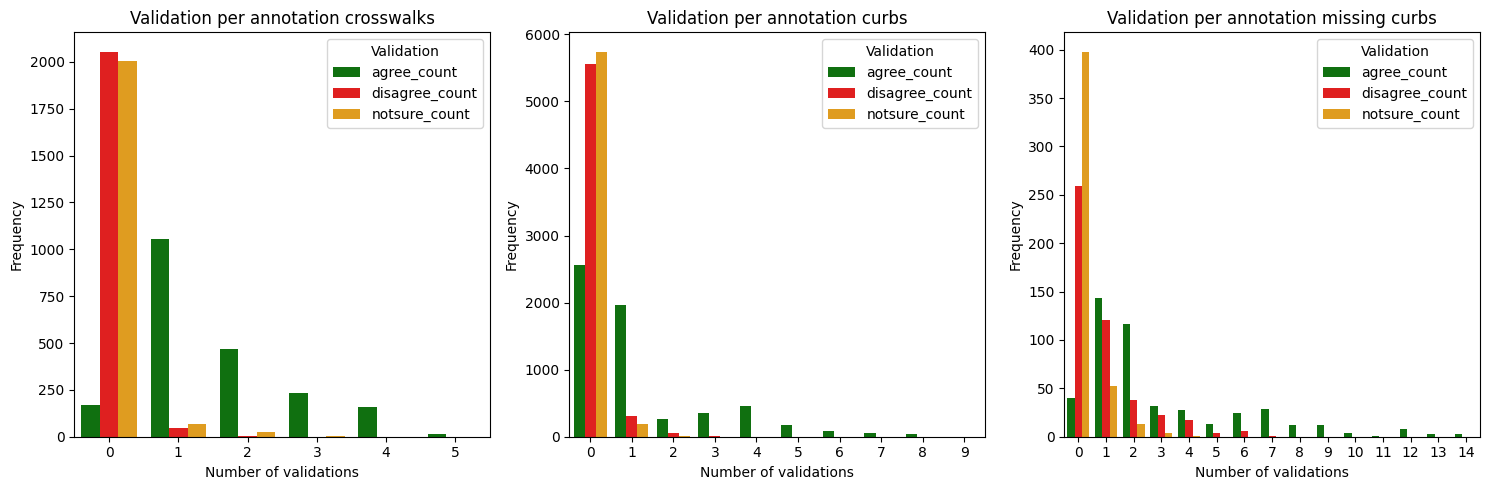

In [7]:
# Set custom palette
custom_palette = {'agree_count': 'green', 'disagree_count': 'red', 'notsure_count': 'orange'}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    
def validation_plot(df, name, axis):
    # Melt the DataFrame to long format
    melted_df = df.melt(value_vars=['agree_count', 'disagree_count', 'notsure_count'], var_name='Count Type', value_name='Count')

    # Plot the count of occurrences for each type of validation
    sns.countplot(data=melted_df, x='Count', hue='Count Type', palette=custom_palette, ax=axs[axis])
    
    # Set labels
    axs[axis].set_xlabel('Number of validations')
    axs[axis].set_ylabel('Frequency')
    axs[axis].set_title('Validation per annotation ' + name)
    axs[axis].legend(title='Validation')
    
# Plot all dataframes
validation_plot(crosswalks, "crosswalks", 0)
validation_plot(curbs, "curbs", 1)
validation_plot(missing_curbs, "missing curbs", 2)

    
plt.tight_layout()
plt.show()

The agree validation is most prevalent among the annotations which is a good sign.

A few types of datapoints should be removed to ensure the best possible data quality:

- Datapoints that have more disagree than agree counts
- Datapoints that have more combined disagree and not sure counts than agree counts
- Datapoints that have no agree counts

In [8]:
# Find datapoints that a majority disagrees on
disagreed = combined[combined['disagree_count'] > combined['agree_count']]

# Find datapoints that have more disagree and not sure counts than agree counts
disagreed_unsure = combined[combined['disagree_count'] + combined['notsure_count'] > combined['agree_count']]

# Find datapoints that have no agree counts
not_validated = combined[combined["agree_count"] == 0]

removed = combined[(combined['disagree_count'] > combined['agree_count']) | 
                    ((combined['disagree_count'] + combined['notsure_count']) > combined['agree_count']) |
                    ((combined["agree_count"] == 0))]

# Print results
print("Types of annotations removed:")
print("Number of datapoints with more disagree than agree counts:", len(disagreed))
print("Number of datapoints with more disagree + not sure than agree counts:", len (disagreed_unsure))
print("Number of datapoints with no agree counts:", len(not_validated))
print("------------------------------------------------------------------------------------")


# Remove datapoints from original data
combined = combined[(combined['disagree_count'] < combined['agree_count']) & 
                    ((combined['disagree_count'] + combined['notsure_count']) < combined['agree_count']) &
                    ((combined["agree_count"] != 0))]


# Print results
print("Annotations removed per accessibility metric:")
print(removed['label_type'].value_counts())

Types of annotations removed:
Number of datapoints with more disagree than agree counts: 0
Number of datapoints with more disagree + not sure than agree counts: 182
Number of datapoints with no agree counts: 2765
------------------------------------------------------------------------------------
Annotations removed per accessibility metric:
CurbRamp      2562
Crosswalk      171
NoCurbRamp      50
Name: label_type, dtype: int64


#### Is temporary

is_temporary indicates whether an annotation is temporary. These annotations will also be removed as they are outliers and do not portray the permanent pedestrian infrastructure.

In [9]:
# Find temporary annotations
removed = combined[combined['is_temporary'] == True]

# Print results
print("Number of temporary annotations:", len(removed))
print("-------------------------------------------------------")

# Remove datapoints from original data
combined = combined[combined['is_temporary'] != True]

# Print results
print("Annotations removed per accessibility metric:")
print(removed['label_type'].value_counts())

Number of temporary annotations: 2
-------------------------------------------------------
Annotations removed per accessibility metric:
Crosswalk     1
NoCurbRamp    1
Name: label_type, dtype: int64


#### Image capture date

The data that is used would ideally be up to date. The image_capture_date indicates when the Google Street View panorama used to label the data was taken and thus shows how recent the data is. The dates should be compared with the other data sources used in order to estimate whether there is a significant difference that might lead to issues. This can be the case as the Project Sidewalk data will be used for validation but is not the data that will be fed to the model.

In [10]:
# Get unique dates
print(sorted(combined['image_capture_date'].unique()))

['2008-06', '2008-07', '2009-05', '2009-08', '2010-09', '2010-10', '2014-05', '2014-06', '2014-07', '2014-08', '2015-05', '2015-06', '2015-07', '2015-08', '2016-04', '2016-05', '2016-06', '2016-08', '2017-06', '2017-07', '2017-09', '2018-05', '2018-06', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-03', '2021-04', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-06', '2022-07', '2022-08', '2022-09', '2022-11', '2023-06']


We see that the date of the images ranges from 2008 to 2023. We should now explore how the annotations are distributed over the years.

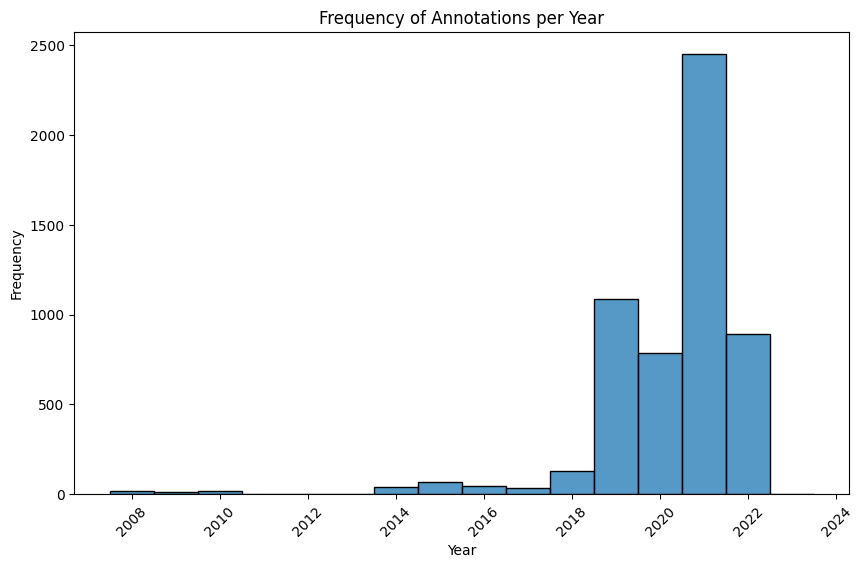

In [11]:
# Convert dates to datetime objects
combined['image_capture_date'] = pd.to_datetime(combined['image_capture_date'])

# Extract years from dates
combined['year'] = combined['image_capture_date'].dt.year

# Plot histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=combined, x='year', discrete=True, kde=False)

# Set labels
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Annotations per Year')
plt.xticks(rotation=45)

# Show plot
plt.show()

Most annotations are based on panoramic images from 2019 to 2022. 

### Final data

Lastly we will check how many annotations per accessibilty remain after the filtering.

In [12]:
# Print number of remaining annotations
print(combined['label_type'].value_counts())

CurbRamp      3301
Crosswalk     1919
NoCurbRamp     357
Name: label_type, dtype: int64


## Integrating data

In the research, data from different sources will be integrated. Firstly, data from an aerial image will be used to detect crosswalks using an online tool (Tile2Net). The detected crosswalks will be validated using the Project Sidewalk annotations. Lastly, the validated crosswalks will be transferred to point cloud data of Amsterdam. 

In order to succesfully integrate data from these different sources, we need to examine two things.
- **Coordinate systems**: as we want to integrate annotations from different sources, we need to know the coordinate system used by each one. Additionally, the precision of the coordinates should be checked.
- **Compatibility**: the aerial images should be checked for compatibility with Tile2Net. This concerns matters such as resolution and clarity.

If there are differences, appropriate transformations or adjustments have to be implemented to ensure compatibility and accuracy.

### Aerial image

The aerial image used for this project is the yearly aerial image of Amsterdam from 2023 (https://www.amsterdam.nl/bestuur-organisatie/organisatie/dii/basisinformatie/basisinformatie/registraties/luchtfoto's/). 

#### Tile2Net
Tile2Net is a tool for automated mapping of pedestrian infrastructure from aerial imagery. The tool detects roads, sidewalks, crosswalks, and footpaths. The tool takes tile images that follow the Slippy Tile Map system as input. These tile images are raster tiles delivered as PNG files which are square-shaped. Following the Slippy Tile Map system, all tiles should be 256x256 pixels. Each tile should be defined as {X_tile}_{Y_tile}.png. the X and Y coordinates are the position of the top left corner of the image. These coordinates are based on the zoom level and number of tiles but there is a mathematical way to convert them into geographical coordinates.

The input folder can look as follows:

```python
raster = Raster(
    location=location,
    name='central_park',
    input_dir='<path/to/tiles/z/y/x.png>',
    zoom=19,
)
raster
```
In which z is the zoom level of the tiles. 

#### Format
The aerial image is in ECW (Enhanced Compression Wavelet) format. This is a proprietary wavelet compression image format. These files require a viewer which can be downloaded freely (https://download.hexagongeospatial.com). This viewer can be used to export the ECW image to the tiles as required by Tile2Net.

#### Coordinates

### Point Clouds

Point clouds can be seen as 3D photos. Each datapoint depicts a point in space depicted by an x, y, and z coordinate. Additionally, each datapoint has an R, G, and B value depicting its color and an intesity value which indicates the return strength of the laser pulse that generated the point. This information can be used to accurately map the exact position and measurement of objects.

The city of Amsterdam is captured as one point cloud but can be segmented into smaller segments for easier processing. 

The coordinates 